In [51]:
import os
import pandas as pd
import numpy as np
import json
import xarray as xr
import matplotlib.pylab as plt

In [49]:
instance_path = '../experiments/test1000'
data_path = '../data/'

In [35]:
df = pd.read_csv('../data/real_covid_data.csv')
df['date'] = pd.to_datetime(df['date'])

In [36]:
def get_pivot_xarray(df, index, columns, values):
    pivot = df.pivot(index=index, columns=columns, values=values)
    return xr.DataArray(pivot.values,
                    dims=(index, columns),
                    coords={
                        columns: pivot.columns.tolist(),
                        index: pivot.index.tolist(),
                    })


real_prevalence = get_pivot_xarray(df, index='id', columns='date', values='total_cases')
real_incidence = get_pivot_xarray(df, index='id', columns='date', values='new_cases')

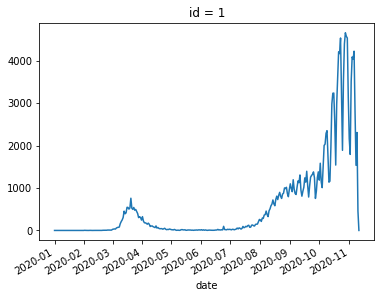

In [39]:
real_incidence.sel(id=1).plot()

In [52]:
def load_config(data_path):
    config_path = os.path.join(data_path, 'config.json')
    with open(config_path) as f:
        return json.load(f)



In [78]:
import os
import json
import numpy as np
import xarray as xr
import pandas as pd


def load_parameters(instance_path):
    return pd.read_csv(os.path.join(instance_path, 'params.csv'))


def load_seeds(instance_path, data_path, rename=False):
    seeds_file = os.path.join(instance_path, 'seeds.csv')
    if os.path.isfile(seeds_file):
        df = pd.read_csv(seeds_file)
        if 'idx' in df.columns and 'seed' in df.columns:
            # this seeds file does not contain one set of seeds per row
            # instead, it contains one unique set of seeds in column format
            return None

        if rename:
            config = load_config(data_path)
            names = {str(d['patch_idx']): d['patch_name'] for d in config['seeds']}
            df = df.rename(columns=names)

        return df


def load_ccaa_data(data_path):
    ccaa_df = pd.read_csv(os.path.join(data_path, 'ccaa.csv'))
    ccaa_names = ccaa_df['name'].to_list()
    ccaa_ids = ccaa_df['id'].to_list()
    ccaa_pop = ccaa_df['population'].to_list()
    ccaa_area = ccaa_df['area'].to_list()
    return ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area


def load_config(data_path):
    config_path = os.path.join(data_path, 'config.json')
    with open(config_path) as f:
        return json.load(f)


def load_simulation_results(instance_path, data_path):
    config = load_config(data_path)
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    params_df = load_parameters(instance_path)
    
    S = np.load(os.path.join(instance_path, 'output/'+config['data']['sim_data_filename']))
    S = np.moveaxis(S, 2, 0)

    date_range = pd.date_range(config['first_day_simulation'], config['last_day_simulation'])
    if config['data']['skip_first_day_simulation']:
        date_range = date_range[1:]
    
    # convert to xarray
    S = xr.DataArray(S, 
                    dims=('simulation', 'patch', 'date'),
                    coords={
                        'date': date_range,
                        'patch': ccaa_names,
                        'simulation': params_df['id']
                    })

    # training set
    train_dates = pd.date_range(config['first_day_train'], config['last_day_train'])
    if config['data']['skip_first_day_simulation']:
        train_dates = train_dates[1:]
    S_train = S.sel(date=train_dates)

    # test set
    test_dates = pd.date_range(config['last_day_train'], config['last_day_simulation'])
    if config['data']['skip_first_day_simulation']:
        test_dates = test_dates[1:]
    S_test = S.sel(date=test_dates)

    # print("Simulations: (n_sim, n_patches, n_days_simulation)=", S.shape)
    return S, S_train, S_test


def load_simulation_file(instance_path, data_path, filename, skip_first):
    config = load_config(data_path)
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    params_df = load_parameters(instance_path)
    
    S = np.load(os.path.join(instance_path, 'output/'+filename))
    S = np.moveaxis(S, 2, 0)

    date_range = pd.date_range(config['first_day_simulation'], config['last_day_simulation'])
    if skip_first:
        date_range = date_range[1:]
    
    # convert to xarray
    S = xr.DataArray(S, 
                    dims=('simulation', 'patch', 'date'),
                    coords={
                        'date': date_range,
                        'patch': ccaa_names,
                        'simulation': params_df['id']
                    })

    # training set
    train_dates = pd.date_range(config['first_day_train'], config['last_day_train'])
    if config['data']['skip_first_day_simulation']:
        train_dates = train_dates[1:]
    S_train = S.sel(date=train_dates)

    # test set
    test_dates = pd.date_range(config['last_day_train'], config['last_day_simulation'])
    if config['data']['skip_first_day_simulation']:
        test_dates = test_dates[1:]
    S_test = S.sel(date=test_dates)

    # print("Simulations: (n_sim, n_patches, n_days_simulation)=", S.shape)
    return S, S_train, S_test



def load_real_incidence(data_path, filename):
    config = load_config(data_path)
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    df = pd.read_csv(os.path.join(data_path, filename))

    R = df.pivot(index='id', columns='date', values='new_cases')

    first_day_real = R.columns[0]
    last_day_real = R.columns[-1]
    dates_real = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_real, last_day_real)]
    patches_ids = R.index.tolist()

    assert all(patches_ids == ccaa_df['id']) # ensure correct ordering of patch ids
    assert all(dates_real == R.columns) # ensure real data contains a full range of dates

    # convert to xarray
    R = xr.DataArray(R.values,
                    dims=('patch', 'date'), 
                    coords={
                        'date': pd.date_range(first_day_real, last_day_real),
                        'patch': ccaa_names,
                    })

    # apply window mean if desired
    if config['window_mean_real_data']:
        window_size = config.get('window_mean_size', 7) # INFO: default to 7
        R = R.rolling(date=window_size, min_periods=1, center=True).mean()

    return R


def load_real_data(data_path):
    config = load_config(data_path)
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    df = pd.read_csv(os.path.join(data_path, config['data']['real_data_filename']))
    df['id'] = df['cod_ine']

    R = df.pivot(index='id', columns='fecha', values='total')

    first_day_real = R.columns[0]
    last_day_real = R.columns[-1]
    dates_real = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_real, last_day_real)]
    patches_ids = R.index.tolist()

    assert all(patches_ids == ccaa_df['id']) # ensure correct ordering of patch ids
    assert all(dates_real == R.columns) # ensure real data contains a full range of dates

    # convert to xarray
    R = xr.DataArray(R.values,
                    dims=('patch', 'date'), 
                    coords={
                        'date': pd.date_range(first_day_real, last_day_real),
                        'patch': ccaa_names,
                    })

    # apply window mean if desired
    if config['window_mean_real_data']:
        window_size = config.get('window_mean_size', 7) # INFO: default to 7
        R = R.rolling(date=window_size, min_periods=1, center=True).mean()

    return R


def load_simulations_and_real(instance_path, data_path):
    """
    Returns three matrices:
    - S: full simulation matrix, containing one time serie for each patch, for each set of parameters
    - S_train: same as S, but for the fitting date range specified in config.json
    - R: real data, containing one time serie for each patch
    """
    config = load_config(data_path)
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)

    S, S_train, S_test = load_simulation_results(instance_path, data_path)
    R = load_real_data(data_path)

    n_sim, n_patches_simulation, n_days_simulation = S.shape
    n_patches_real, n_days_real = R.shape

    assert n_patches_real == n_patches_simulation

    return S, S_train, S_test, R


def build_xarry_from_dict(d, dim, normalize=False):
    tuples = list(d.items())
    coords = [t[0] for t in tuples]
    values = [t[1] for t in tuples]
    w = xr.DataArray(values, dims=(dim), coords={dim: coords})
    if normalize:
        w = w/w.sum()
    return w


def get_population_weights(data_path):
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    return dict(zip(ccaa_names, ccaa_pop))


def get_ones_weights(data_path):
    ccaa_df, ccaa_names, ccaa_ids, ccaa_pop, ccaa_area = load_ccaa_data(data_path)
    return dict(zip(ccaa_names, [1]*len(ccaa_names)))


class ParamSizeError(Exception):
    def __init__(self, message):
        self.message = message


def params2csv(data, config_fname, instance_dir):

    with open(config_fname) as fh:
        config_dict = json.load(fh)

    epi_columns = config_dict['epi_param_columns']
    seeds_columns = config_dict['seed_patches_idx']

    epi_columns = config_dict['epi_param_columns']
    seeds_columns = config_dict['seed_patches_idx']

    epi_data = [[row[i] for i in epi_columns] for row in data]
    seeds_data = [[row[i] for i in seeds_columns] for row in data]
    
    if len(epi_data) > 0:
        csv_fname = os.path.join(instance_dir, "params.csv")
        df_params = pd.DataFrame(epi_data, columns=epi_columns)
        df_params.index.name = 'id'
        df_params.to_csv(csv_fname)

    if len(seeds_data) > 0:
        csv_fname = os.path.join(instance_dir, "seeds.csv")
        df_seeds = pd.DataFrame(seeds_data, columns=seeds_columns)
        df_seeds.index.name = 'id'
        df_seeds.to_csv(csv_fname)


def get_weights(config, data_path):
    if 'weights' not in config:
        return None
    elif config['weights'] == 'population':
        return get_population_weights(data_path)
    elif config['weights'] == 'ones':
        return get_ones_weights(data_path)
    elif type(config['weights']) == dict:
        return config['weights']
    else:
        print(f"WARN: unrecognized weights: {config['weights']}")
        return None

config = load_config(data_path)

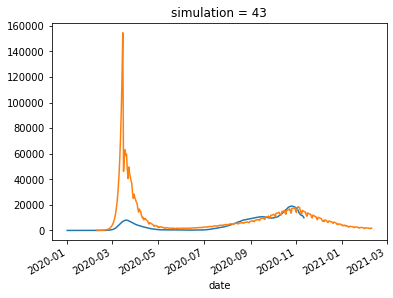

In [89]:
real_incidence = load_real_incidence(data_path, '../data/real_covid_data.csv')
real_incidence.sum(dim='patch').plot()

S, S_train, S_test = load_simulation_file(instance_path, data_path, "incidence.npy", True)
S.sum(dim='patch').sel(simulation=43).plot()